In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import data_utils
import numpy as np

In [28]:
class DrummerDataGenerator():

    def __init__(self, data, controller, x_key, y_key, rng_start, rng_end, batch_size, win_size, normalize=True):
        self.x_data = np.asarray(data[controller][x_key][rng_start:rng_end])
        self.y_data = np.asarray(data[controller][y_key][rng_start:rng_end])
        self.x_key = x_key
        self.y_key = y_key
        self.controller = controller
        self.batch_size = batch_size
        self.win_size = win_size

    # def midi_to_label(self, midi):


    def choose_random_example(self, win_size):
        rnd_idx = np.random.randint(0, self.x_data.shape[0] - win_size)
        x = self.x_data[rnd_idx : rnd_idx + win_size]
        y = self.y_data[rnd_idx : rnd_idx + win_size]
        return x, y

    def generate(self):
        x_iter = iter(self.x_data)
        y_iter = iter(self.y_data)

        while True:
            x_batch = []
            y_batch = []

            for _ in range(self.batch_size):
                x, y = self.choose_random_example(self.win_size)
                x_batch.append(x)
                y_batch.append(y)

            yield np.asarray(x_batch), np.asarray(y_batch)


In [45]:
data = data_utils.load_json("D:/AiDrummer/CapturedMotion/2021-04-09-084809/capture_2021-04-09-084809.json")
batch_size = 32
dataGen = DrummerDataGenerator(data, 
                                controller="c0",
                                x_key="midi_note",
                                y_key="ang_vel",
                                rng_start=1400,
                                rng_end=3300,
                                batch_size=batch_size,
                                win_size=64)
generator = dataGen.generate()

(32, 64, 2) (32, 64, 3)


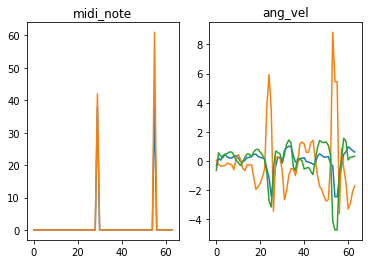

In [48]:
x_b, y_b = next(generator)
print(x_b.shape, y_b.shape)
plt.subplot(121)
plt.title(dataGen.x_key)
plt.plot(x_b[0])
plt.subplot(122)
plt.title(dataGen.y_key)
plt.plot(y_b[0])
plt.show()


In [66]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LSTM, Dense, Input, MaxPooling1D, UpSampling1D

In [68]:
kernel_size = 7

model = Sequential()

model.add(Input(shape=(x_b.shape[1], x_b.shape[2])))
model.add(Conv1D(32, kernel_size, padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(32, kernel_size, padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(64, kernel_size, padding='same'))
model.add(MaxPooling1D())
model.add(LSTM(32, return_sequences=True))
model.add(UpSampling1D(size=2))
model.add(Conv1DTranspose(32, kernel_size, padding="same"))
model.add(UpSampling1D(size=2))
model.add(Conv1DTranspose(16, kernel_size, padding="same"))
model.add(UpSampling1D(size=2))
model.add(Conv1DTranspose(8, kernel_size, padding="same"))

model.add(Conv1D(y_b.shape[2], kernel_size, padding='same'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 64, 32)            480       
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 16, 32)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16, 64)            14400     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 32)           

In [71]:
model.compile(optimizer="adam",
            loss=tf.keras.losses.MSE,
            metrics=["MSE"])
model.fit(generator, 
            batch_size=batch_size,
            epochs=10, 
            steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 27s 32ms/step - loss: 2.1954 - MSE: 2.1954
Epoch 2/10
500/500 [==============================] - 24s 47ms/step - loss: 1.6419 - MSE: 1.6419
Epoch 3/10
500/500 [==============================] - 24s 48ms/step - loss: 1.4627 - MSE: 1.4627
Epoch 4/10
500/500 [==============================] - 24s 48ms/step - loss: 1.3640 - MSE: 1.3640
Epoch 5/10
500/500 [==============================] - 22s 45ms/step - loss: 1.2892 - MSE: 1.2892
Epoch 6/10
500/500 [==============================] - 25s 50ms/step - loss: 1.2431 - MSE: 1.2431
Epoch 7/10
500/500 [==============================] - 38s 76ms/step - loss: 1.2228 - MSE: 1.2228
Epoch 8/10
419/500 [========================>.....] - ETA: 6s - loss: 1.1850 - MSE: 1.1850

KeyboardInterrupt: 